In [1]:
using Pkg
Pkg.activate("CountySplit"; shared=true) # you'll need to make a shared environment for GerryChain for this to work!
using GerryChain
using Statistics
using Serialization

 Activating environment at `C:\Users\matth\.julia\environments\CountySplit\Project.toml`


In [2]:
SHAPEFILE_PATH = "./PA_VTD.json"
POPULATION_COL = "TOT_POP"
ASSIGNMENT_COL = "538GOP_PL"

"538GOP_PL"

In [3]:
# Initialize graph and partition
graph = BaseGraph(SHAPEFILE_PATH, POPULATION_COL, ASSIGNMENT_COL)
partition = Partition(graph, ASSIGNMENT_COL)

# Define parameters of chain (number of steps and population constraint)
pop_constraint = PopulationConstraint(graph, POPULATION_COL, 0.02)
num_steps = 10
print()

In [4]:
# Initialize Election of interest
election = Election("SEN10", ["SEN10D", "SEN10R"], graph.num_dists)

# Define election-related metrics and scores
election_metrics = [
    vote_count("count_d", election, "SEN10D"),
    efficiency_gap("efficiency_gap", election, "SEN10D"),
    seats_won("seats_won", election, "SEN10D"),
    mean_median("mean_median", election, "SEN10D")
]

scores = [
        DistrictAggregate("presd", "PRES12D"),
        ElectionTracker(election, election_metrics)
]

print()

In [5]:
# Run the chain
println("Running 10-step ReCom chain...")
chain_data = recom_chain(graph, partition, pop_constraint, num_steps, scores)
print()

Running 10-step ReCom chain...


# Score types 

### DistrictAggregate
DistrictAggregate scores are when you sum over the attributes of the nodes in a district. We use this often to calculate say, HVAP/BVAP/VAP of a district. Below is an example of setting up a DistrictAggregate Score to calculate asian pop.

In [6]:
# You would probably want to see what the key for asian people pop is in the graph:

keys(graph.attributes[1])  # the `1` is to inspect the attributes at node 1. 

Base.KeySet for a Dict{String,Any} with 51 entries. Keys:
  "ASIAN_POP"
  "PRES12O"
  "INTPTLAT10"
  "NAME10"
  "2011_PLA_1"
  "INTPTLON10"
  "538DEM_PL"
  "SEN10D"
  "BLACK_POP"
  "ATG12R"
  "T16PRESD"
  "GOV10D"
  "boundary_node"
  "VTDST10"
  "T16PRESR"
  "USS12D"
  "F2014GOVD"
  "REMEDIAL_P"
  "GEOID10"
  "GOV"
  "NATIVE_POP"
  "NAMELSAD10"
  "area"
  "MTFCC10"
  "AWATER10"
  ⋮

In [7]:
# how you would frame the Score
DistrictAggregate("asian", "ASIAN_POP")

DistrictAggregate("asian", "ASIAN_POP")

### DistrictScore
DistrictScores are when you compute something about a district that is self-contained in a district. We sometimes use this kind of computation for things like computing vote shares in a district (% Dem), and when it gets slightly more involved than just simply summing attributes like DistrictAggregate does. 

To build a DistrictScore you have to pass in a function that will be applied to each district, and that function should take 3 arguments, even if some are unused. The function signature looks like
   `score_fn(graph::BaseGraph, district_nodes::BitSet, district::int)`
   
The example below illustrates a simple example when perhaps somehow you find yourself interested in computing the number of edges within a district. 

In [8]:
function num_edges_within_dist(graph, district_nodes, district)
    """ Computes the number of edges within each district of the plan.
    """
    all_edges = []
    for node in district_nodes, neighbor in graph.neighbors[node]
        if neighbor in district_nodes
            edge = graph.adj_matrix[node, neighbor]
            push!(all_edges, edge)
        end
    end
    return length(unique(all_edges))
end

# how you would formulate this score
DistrictScore("edges_within_dist", num_edges_within_dist)
#              ^ name of score     ^ score_fn() to be applied on each district

DistrictScore("edges_within_dist", num_edges_within_dist)

### PlanScore

Some scores are plan-wide, for example cut edges. Many things we are interested in are implemented as PlanScores, like number of seats won by a party, mean-median score, efficiency gap etc. 

Below we illustrate a few examples on how to construct a PlanScore for the case when you want to compute, say, 
* the maximum number of blocks in each district.
* a score that returns True if you have a higher number of cut edges than the previous plan, else False
* an array of boundary nodes of the district with the highest population

In [9]:
function num_max_blocks(graph, partition)
    """
    """
    return maximum([length(nodes) for nodes in partition.dist_nodes])
end

function higher_num_cut_edges_than_parent(graph, partition)
    """
    """
    if partition.parent isa Partition & partition.num_cut_edges > partition.parent.num_cut_edges
        return True
    end
    return False
end
       
function boundary_nodes_highest_pop_dist(graph, partition)
    """
    """    
    # get dist with highest population
    highest_pop_dist = argmax(partition.dist_populations)
    
    # get all the edges 
    boundary_nodes = []
    for node in partition.dist_nodes[highest_pop_dist], neighbor in graph.neighbors[node]
        edge = graph.adj_matrix[node, neighbor]
        
        if partition.cut_edges[edge] == 1 
            push!(boundary_nodes, node)
        end
    end
    
    return boundary_nodes
end 

# how to formulate these scores
PlanScore("num_max_blocks", num_max_blocks)
PlanScore("higher_num_cut_edges_than_parent", higher_num_cut_edges_than_parent)
PlanScore("boundary_nodes_highest_pop_dist", boundary_nodes_highest_pop_dist)

PlanScore("boundary_nodes_highest_pop_dist", boundary_nodes_highest_pop_dist)

## Acceptance functions

Unlike the Python GerryChain that returns True or False from its acceptance functions, acceptance functions in the Julia implementation instead return a probability of accepting a proposal. All acceptance functions take in a partition as an argument, even if unused.

Illustrated are 3 acceptance functions that, respectively:
* accept half the time
* accepts with a probability of 0.8 if it has a higher number of cut_edges than its parent, 0.2 otherwise

In [10]:
function accept_half_the_time_randomly(partition)
    """ Acceptance score that accepts a new state with 50% probability
    """
    return 0.5
end

function accept_observing_parent_cut_edges(partition)
    """ Accepts if the cut edges decrease in the new state with a probability
        of 80%, 20% otherwised
    """
    if partition.parent isa Partition
        if partition.parent.num_cut_edges > partition.num_cut_edges 
            return 0.8
        else 
            return 0.2
        end
    else
        return 1 # simply accept the very first step
    end
end

accept_observing_parent_cut_edges (generic function with 1 method)

### Run a chain with all of these new scores/ acceptance functions

In [11]:
scores = [
    DistrictAggregate("asian", "ASIAN_POP"),
    DistrictScore("edges_within_dist", num_edges_within_dist),
    PlanScore("num_max_blocks", num_max_blocks),
    PlanScore("boundary_nodes_highest_pop_dist", boundary_nodes_highest_pop_dist)
]

# Run the chain
println("Running 10-step ReCom chain...")
num_steps = 10
chain_data = recom_chain(graph, 
                         partition, 
                         pop_constraint, 
                         num_steps, 
                         scores, 
                         acceptance_fn=accept_observing_parent_cut_edges)
print()

Running 10-step ReCom chain...


### New! Built-in plotting

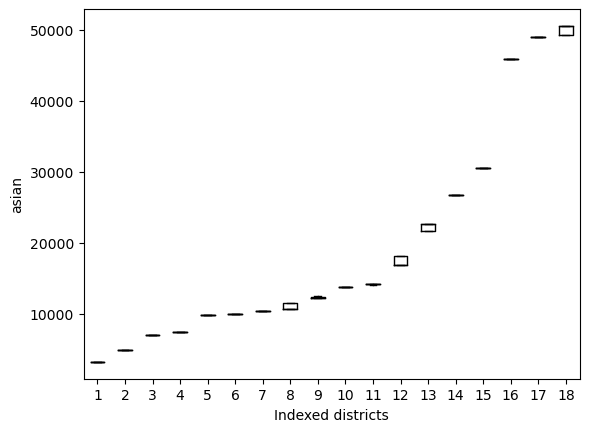

PyObject Text(24.0, 0.5, 'asian')

In [12]:
score_boxplot(chain_data, "asian")

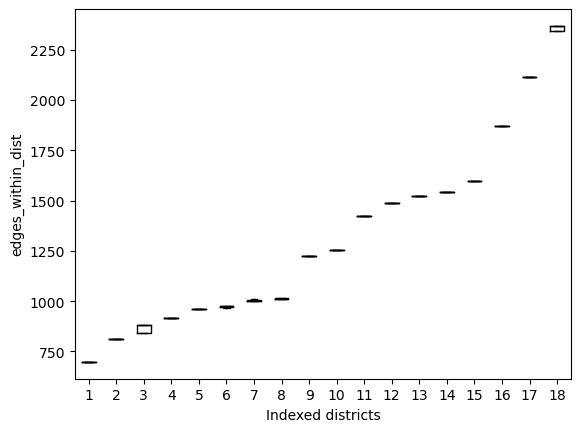

PyObject Text(24.140625, 0.5, 'edges_within_dist')

In [13]:
score_boxplot(chain_data, "edges_within_dist")

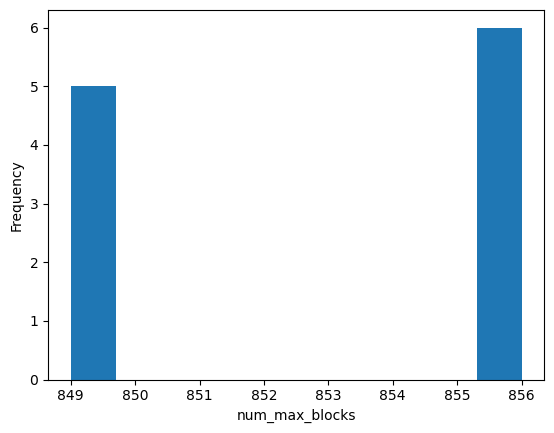

PyObject Text(0.5, 24.140625, 'num_max_blocks')

In [14]:
score_histogram(chain_data, "num_max_blocks")

### Election scores!

In [20]:
election = Election("SEN12", ["USS12D", "USS12R"], graph.num_dists)

partisan_metrics = [
  efficiency_gap("efficiency_gap", election, "USS12D"),
  seats_won("seats_won", election, "USS12D"),
  mean_median("mean_median", election, "USS12D"),
  vote_share("dem_vote_share", election, "USS12D")
]

scores = [
    ElectionTracker(election, partisan_metrics)
]

# Run the chain
println("Running 100-step ReCom chain...")
num_steps = 100
chain_data = recom_chain(graph, 
                         partition, 
                         pop_constraint, 
                         num_steps, 
                         scores, 
                         acceptance_fn=accept_observing_parent_cut_edges)
print()

Running 100-step ReCom chain...


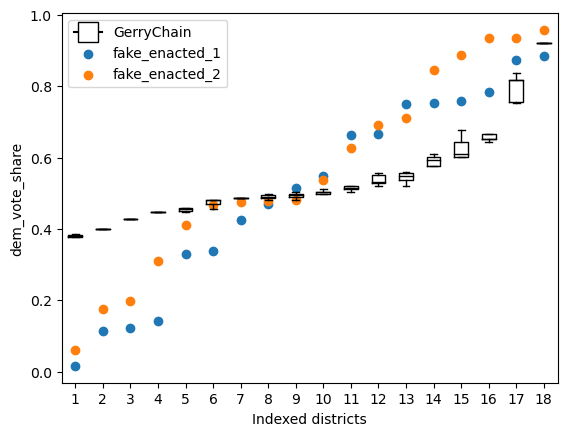

PyObject Text(24.140625000000007, 0.5, 'dem_vote_share')

In [22]:
fake_vote_1 = rand(18)
fake_vote_2 = rand(18)
score_boxplot(chain_data, "dem_vote_share", comparison_scores=[("fake_enacted_1", fake_vote_1), ("fake_enacted_2", fake_vote_2)])

### New! Saving Scores

In [6]:
serialize("example.jld", chain_data)

# You should have an example.jld saved in your local directory

In [7]:
# To load the file, do this:
chain_data = deserialize("example.jld")
print()

In [8]:
# And if you wish to save the scores as a .csv or a .json, ...
save_scores("data.csv", chain_data)

### Score functions that rely on some outer state

When you specify a custom score function, the function should expect as inputs either the graph and partition objects (if it's a custom PlanScore) or the graph, district nodes, and district ID (if it's a custom DistrictScore). In practice, you might find that your score function relies on some other variables. Here's an example:

Imagine that you want to write a `PlanScore` that tracks the number of county splits in a districting plan at each step of the chain. However, you want to use this score function to count county splits using county divisions from different years (say, 2000 and 2015). One way you could achieve this effect is to have two score functions:

In [16]:
function county_splits_2000(graph::BaseGraph, partition::Partition)
    counties = [Set([graph.attributes[n]["COUNTY_2000"] for n in d]) for d in partition.dist_nodes]
    num_splits = 0
    for val in possible_vals
        val_districts = 0 # number of districts that contain at least one node with this value
        for d in dist_vals
            if in(val, d)
                val_districts += 1
            end
            if val_districts > 1 # if value appears in multiple districts, add 1 to split
                num_splits += 1
                break
            end
        end
    end
    return num_splits
end


function county_splits_2015(graph::BaseGraph, partition::Partition)
    counties = [Set([graph.attributes[n]["COUNTY_2015"] for n in d]) for d in partition.dist_nodes]
    num_splits = 0
    for val in counties
        val_districts = 0 # number of districts that contain at least one node with this value
        for d in dist_vals
            if in(val, d)
                val_districts += 1
            end
            if val_districts > 1 # if value appears in multiple districts, add 1 to split
                num_splits += 1
                break
            end
        end
    end
    return num_splits
end


scores = [
    PlanScore("splits_2000", county_splits_2000),
    PlanScore("splits_2015", county_splits_2015)
]


2-element Array{PlanScore,1}:
 PlanScore("splits_2000", county_splits_2000)
 PlanScore("splits_2015", county_splits_2015)

But this seems pretty clunky! What's a better, more concise way to do this? 

The answer lies in the fact that Julia treats functions as first class objects! We'll write a function that returns a scoring function, like so:

In [17]:
function num_splits(name::String, county_col::String)::PlanScore
    """ Returns a PlanScore that tracks the number of cut edges in a particular
        plan.
    """
    function score_fn(graph::BaseGraph, partition::Partition)
        counties = [Set([graph.attributes[n][county_col] for n in d]) for d in partition.dist_nodes]
        num_splits = 0
        for val in counties
            val_districts = 0 # number of districts that contain at least one node with this value
            for d in dist_vals
                if in(val, d)
                    val_districts += 1
                end
                if val_districts > 1 # if value appears in multiple districts, add 1 to split
                    num_splits += 1
                    break
                end
            end
        end
        return num_splits
    end
    return PlanScore(name, score_fn)
end

scores = [
    num_splits("splits_2000", "COUNTY_2000"),
    num_splits("splits_2000", "COUNTY_2015")
]


2-element Array{PlanScore,1}:
 PlanScore("splits_2000", var"#score_fn#21"{String}("COUNTY_2000"))
 PlanScore("splits_2000", var"#score_fn#21"{String}("COUNTY_2015"))